#<b>Detecting Malaria In Red Blood Cell Using Convolutional Neural Networks By Simon Joshi

#<b>Objective:
- Build an efficient computer vision model to detect malaria. 
- The model should identify whether the image of a red blood cell is that of one infected with malaria or not, and classify the same as parasitized or uninfected, respectively. 

###<b> Mounting the Drive

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###<b>Loading libraries</b>

In [ ]:
#Importing libraries required to load the data

import cv2
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

In [ ]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/CNN Project Malaria Detection /cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)            
            #Resizing each image to (224,224)
            image=image.resize((SIZE, SIZE))
           
            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
                        
            #Resizing each image to (128,128)
            image= image.resize((SIZE, SIZE))
            
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Convert the Train Data to Gaussian Blurring

In [ ]:
train_images_gauss=[]   # to hold the Gaussian image array
for i in np.arange(0,24958,1):
  a=cv2.GaussianBlur(train_images[i], (5, 5), 0)
  train_images_gauss.append(a)
train_images_gauss=np.array(train_images_gauss)

Convert the Test Data to Gaussian Blurring

In [ ]:
test_images_gauss=[]   # to hold the Gaussian image array
for i in np.arange(0,2600,1):
  a=cv2.GaussianBlur(test_images[i], (5, 5), 0)
  test_images_gauss.append(a)
test_images_gauss=np.array(test_images_gauss)

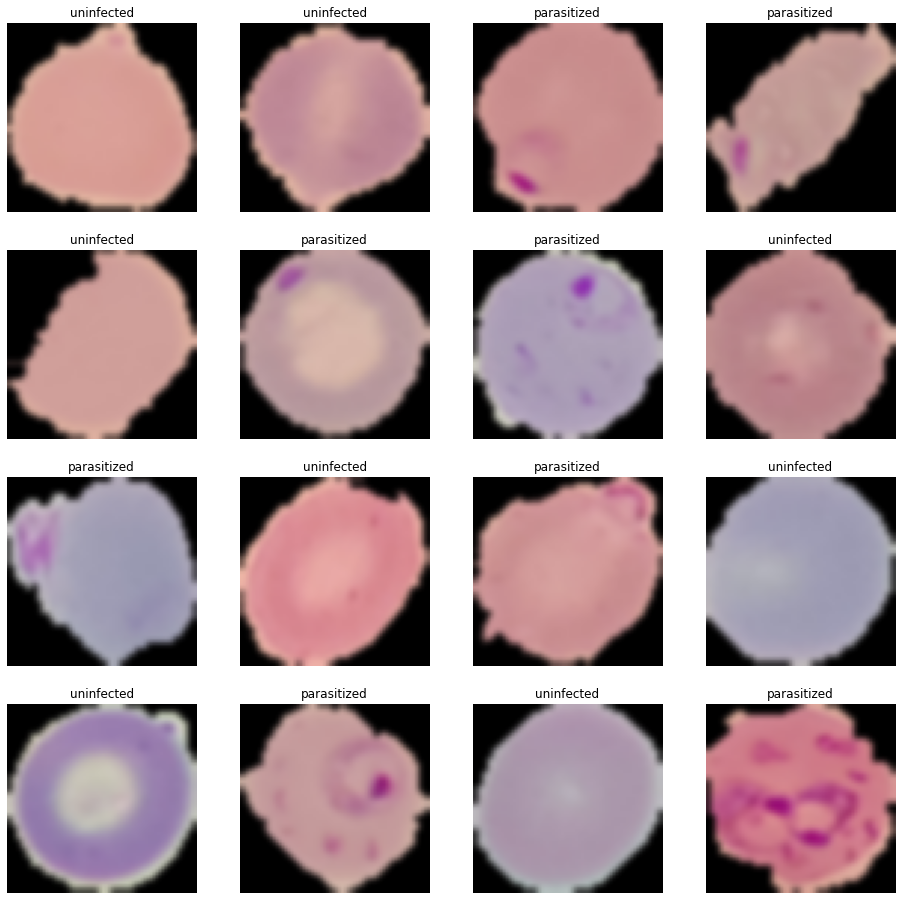

In [ ]:
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images_gauss.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images_gauss[index])
    plt.axis('off')

###<b>Normalize the images

In [ ]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images_gauss = (train_images_gauss/255).astype('float32')
test_images_gauss = (test_images_gauss/255).astype('float32')

###<B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [ ]:

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [ ]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images_gauss,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 38s 12ms/step - loss: 0.4804 - accuracy: 0.7591 - val_loss: 0.4537 - val_accuracy: 0.8672
Epoch 2/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1904 - accuracy: 0.9306 - val_loss: 0.2657 - val_accuracy: 0.9497
Epoch 3/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1611 - accuracy: 0.9441 - val_loss: 0.1762 - val_accuracy: 0.9694
Epoch 4/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1479 - accuracy: 0.9502 - val_loss: 0.1837 - val_accuracy: 0.9696
Epoch 5/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1398 - accuracy: 0.9523 - val_loss: 0.2108 - val_accuracy: 0.9645
Epoch 00005: early stopping


####<b> Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(test_images_gauss, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.1565 - accuracy: 0.9512

 Test_Accuracy:- 0.9511538743972778


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



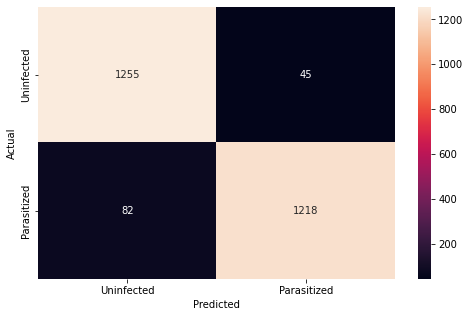

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images_gauss)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

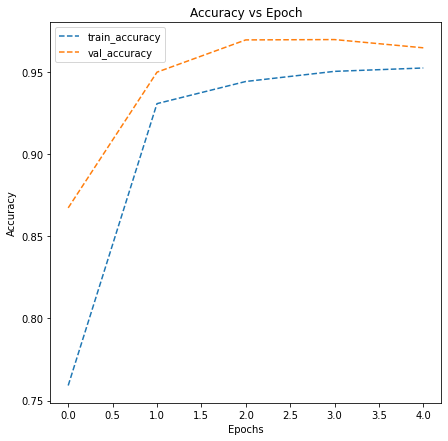

In [ ]:
plot_accuracy(history)

### Observation

* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy
* Slight improvement compared to the original model without any transformation. 

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore let's try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [ ]:
#creating sequential model
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="tanh"))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="tanh"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="sigmoid"))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="sigmoid"))

model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

####<b> Compiling the model

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4,  verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
history1=model1.fit(train_images_gauss,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 16s 23ms/step - loss: 0.6749 - accuracy: 0.6220 - val_loss: 1.0349 - val_accuracy: 0.0000e+00
Epoch 2/20
624/624 [==============================] - 14s 23ms/step - loss: 0.4882 - accuracy: 0.7655 - val_loss: 0.3911 - val_accuracy: 0.9235
Epoch 3/20
624/624 [==============================] - 14s 22ms/step - loss: 0.2285 - accuracy: 0.9321 - val_loss: 0.2112 - val_accuracy: 0.9451
Epoch 4/20
624/624 [==============================] - 14s 22ms/step - loss: 0.1926 - accuracy: 0.9374 - val_loss: 0.2028 - val_accuracy: 0.9595
Epoch 5/20
624/624 [==============================] - 14s 22ms/step - loss: 0.1655 - accuracy: 0.9461 - val_loss: 0.1866 - val_accuracy: 0.9617
Epoch 6/20
624/624 [==============================] - 14s 22ms/step - loss: 0.1599 - accuracy: 0.9502 - val_loss: 0.2085 - val_accuracy: 0.9720
Epoch 7/20
624/624 [==============================] - 14s 22ms/step - loss: 0.1447 - accuracy: 0.9539 - val_loss: 0.2170 - val_accur

####<b> Evaluating the model

In [ ]:
accuracy1 = model1.evaluate(test_images_gauss, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 10ms/step - loss: 0.1430 - accuracy: 0.9569

 Test_Accuracy:- 0.9569230675697327


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1300
           1       0.97      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



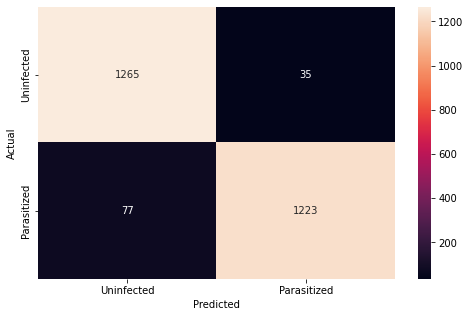

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model1.predict(test_images_gauss)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history1):
    N = len(history1.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history1.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history1.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

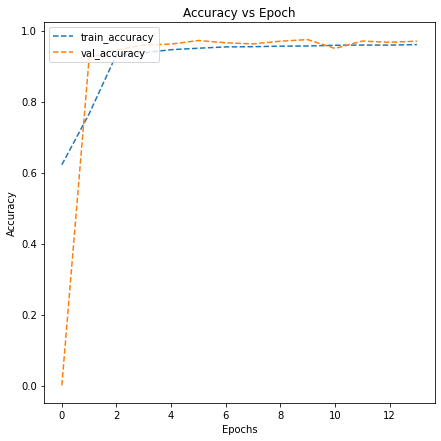

In [ ]:
plot_accuracy(history1)

#### Observation:
* Slight improvement compared to the original model without any transformation. 

####<b>Now let's build a model with LeakyRelu as the activation function:</b><br>
Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))

#Complete this model using BatchNormalization layers and by using LeakyRelu as the activation function
model2.add(Conv2D(32,(3,3),padding="same"))
model2.add(LeakyReLU(0.1))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(32,(3,3),padding="same"))
model2.add(Conv2D(32,(3,3),padding="same"))
model2.add(LeakyReLU(0.1))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(32,(3,3),padding="same"))
model2.add(Conv2D(32,(3,3),padding="same"))
model2.add(LeakyReLU(0.1))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))

model2.add(Flatten())
model2.add(BatchNormalization())

model2.add(Dense(512,activation="relu"))
model2.add(BatchNormalization())

model2.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9

####<b>Compiling the model

In [ ]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [ ]:
history2 = model2.fit(train_images_gauss,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 19s 27ms/step - loss: 0.2705 - accuracy: 0.8923 - val_loss: 0.0392 - val_accuracy: 0.9890
Epoch 2/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1601 - accuracy: 0.9417 - val_loss: 0.1064 - val_accuracy: 0.9635
Epoch 3/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1475 - accuracy: 0.9476 - val_loss: 0.1748 - val_accuracy: 0.9527
Epoch 4/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1354 - accuracy: 0.9499 - val_loss: 0.0915 - val_accuracy: 0.9784
Epoch 5/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1283 - accuracy: 0.9545 - val_loss: 0.1916 - val_accuracy: 0.9403
Epoch 6/20
624/624 [==============================] - 16s 26ms/step - loss: 0.1235 - accuracy: 0.9547 - val_loss: 0.1933 - val_accuracy: 0.9459
Epoch 00006: early stopping


<b>Plotting the train and validation accuracy

In [ ]:
# function to plot train and validation accuracy 
def plot_accuracy(history2):
    N = len(history2.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history2.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history2.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")


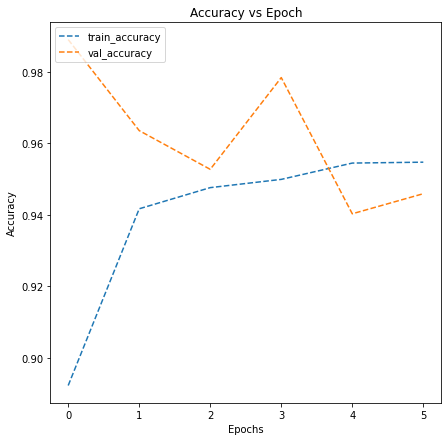

In [ ]:
plot_accuracy(history2)

####<b>Evaluating the model

In [ ]:
# Evaluate the model to calculate the accuracy
accuracy = model2.evaluate(test_images_gauss, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 14ms/step - loss: 0.1573 - accuracy: 0.9454

 Test_Accuracy:- 0.9453846216201782


#####<b>Observations and insights: 
The performance dropped after converting from RGB to Gaussian blurring. 
____

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1300
           1       0.94      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



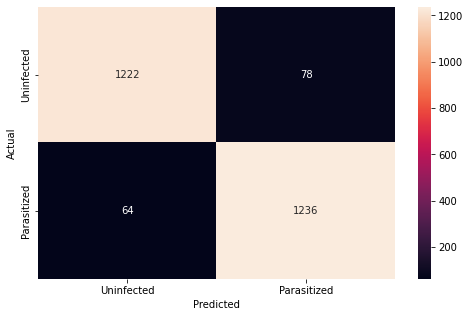

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images_gauss)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Exploring using Image Data Augmentation:**<br>
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images_gauss, train_labels, train_size=0.8, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####**Checking if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.**<br>

####<B>Visualizing Augmented images

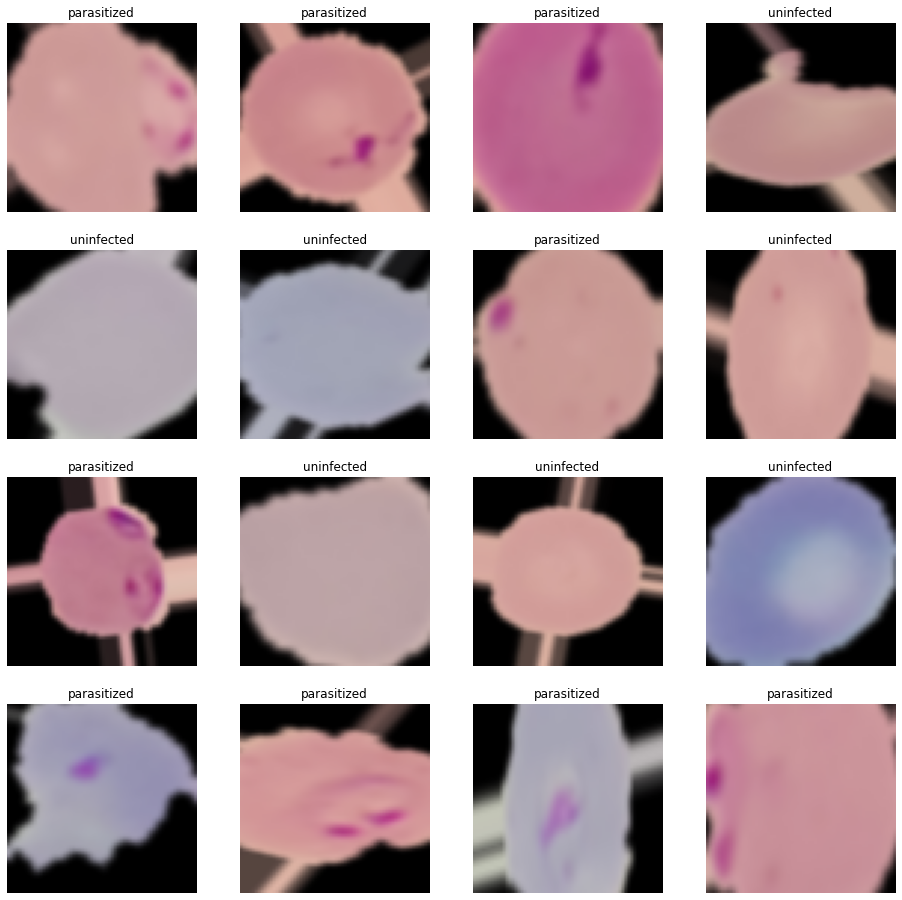

In [ ]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights: 
1. The iterable train images show that the parasitized red blood cells have inclusion. 
2. The images show that hte uninfected red blood cells do not have inclusion. 
____

####<b>Building the Model

In [ ]:
model3 = Sequential()

# Build the model here
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Flatten())

model.add(Flatten())

model3.add(Dense(512,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="softmax"))

# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3,  verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 35s 107ms/step - loss: 0.5417 - accuracy: 0.6993 - val_loss: 0.2279 - val_accuracy: 0.9097
Epoch 2/20
312/312 [==============================] - 34s 108ms/step - loss: 0.2633 - accuracy: 0.9082 - val_loss: 0.1938 - val_accuracy: 0.9449
Epoch 3/20
312/312 [==============================] - 33s 106ms/step - loss: 0.2398 - accuracy: 0.9214 - val_loss: 0.1729 - val_accuracy: 0.9449
Epoch 4/20
312/312 [==============================] - 32s 104ms/step - loss: 0.2178 - accuracy: 0.9286 - val_loss: 0.1743 - val_accuracy: 0.9459
Epoch 5/20
312/312 [==============================] - 34s 109ms/step - loss: 0.2148 - accuracy: 0.9290 - val_loss: 0.1538 - val_accuracy: 0.9551
Epoch 6/20
312/312 [==============================] - 33s 106ms/step - loss: 0.2080 - accuracy: 0.9316 - val_loss: 0.1504 - val_accuracy: 0.9567
Epoch 7/20
312/312 [==============================] - 33s 104ms/step - loss: 0.2036 - accuracy: 0.9311 - val_loss: 0.1429 - val_ac

####<B>Evaluating the model

<b>Plot the train and validation accuracy

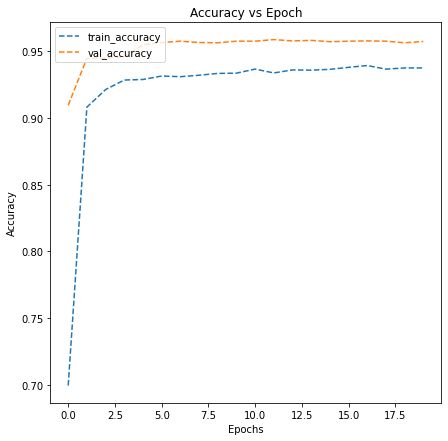

In [ ]:
# plotting the accuracies
plot_accuracy(history3)

In [ ]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images_gauss, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 1s 8ms/step - loss: 0.1359 - accuracy: 0.9558

 Test_Accuracy:- 0.9557692408561707


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1300
           1       0.97      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



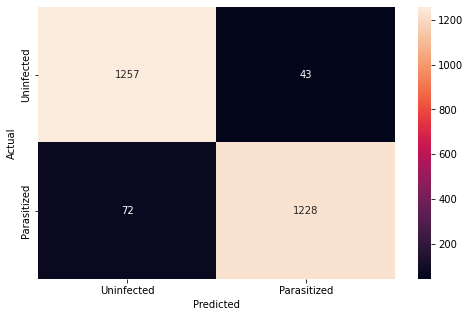

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images_gauss)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Observation:
There is slight improvement after converting applying Gaussian blurring but not sure if we re-run the algorithm we will still be able to get the similar improvement as each time the value changes. 


<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it 
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x) 

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [ ]:
# Compiling the model 
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(train_images_gauss, 
                      train_labels, 
                      epochs=10, 
                      callbacks=callbacks, 
                      batch_size=32, 
                      validation_split=0.2, 
                      verbose=1)


Epoch 1/10
624/624 [==============================] - 30s 45ms/step - loss: 0.2775 - accuracy: 0.8872 - val_loss: 0.1987 - val_accuracy: 0.8856
Epoch 2/10
624/624 [==============================] - 26s 42ms/step - loss: 0.2087 - accuracy: 0.9172 - val_loss: 0.6244 - val_accuracy: 0.7033
Epoch 3/10
624/624 [==============================] - 26s 42ms/step - loss: 0.1924 - accuracy: 0.9231 - val_loss: 0.1355 - val_accuracy: 0.9531
Epoch 4/10
624/624 [==============================] - 26s 42ms/step - loss: 0.1822 - accuracy: 0.9295 - val_loss: 0.3094 - val_accuracy: 0.8848
Epoch 5/10
624/624 [==============================] - 26s 42ms/step - loss: 0.1722 - accuracy: 0.9320 - val_loss: 0.2311 - val_accuracy: 0.9058
Epoch 6/10
624/624 [==============================] - 26s 41ms/step - loss: 0.1697 - accuracy: 0.9336 - val_loss: 0.1326 - val_accuracy: 0.9567
Epoch 7/10
624/624 [==============================] - 26s 42ms/step - loss: 0.1645 - accuracy: 0.9346 - val_loss: 0.2604 - val_accuracy:

<b>Plot the train and validation accuracy

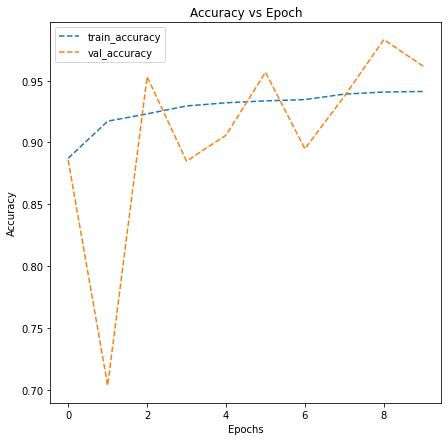

In [ ]:
# plotting the accuracies
plot_accuracy(history4)

#####**Observations and insights:**

*   The train curve keeps on increasing whereas the validation curve is constant and zigzacing
*   Since the val_loss was low, the model stopped early without reaching 20 epochs?

####<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy = model4.evaluate(test_images_gauss, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])


82/82 [==============================] - 4s 41ms/step - loss: 0.2184 - accuracy: 0.9188

 Test_Accuracy:- 0.9188461303710938


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1300
           1       0.96      0.87      0.92      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



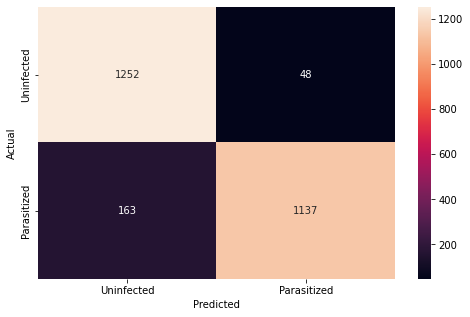

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images_gauss)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Observation
1.	After applying Gaussian blurring the pre-trained model (VGG16) performance dropped. 

Table of result for different iteration:
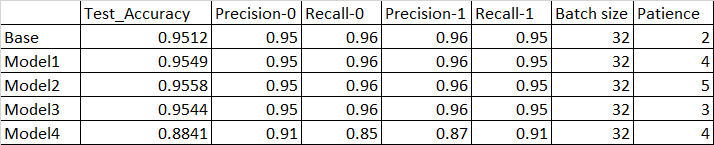

###<b> Observations and Conclusions drawn from the final model:
1. Different models were investigated on different types of images such as the original as-received image, HSV conversion image, Gaussian blurr image, and HSV + Gaussian blurr image.
2. The highest average accuracy using CNN models in all four types of images were 95-96%, we can conclude the data has some noise. Here only HSV + Gaussian blurr is shown. Other images performed similarly. 
3. The images the CNN made false negative and false positive predictions should be downloaded and examined in hopes of understanding why the CNN made these errors. 
4. It is also important to see if all the different types of models using different types of images made the same errors. 
5. Further analysis on the errors the CNN models made should be performed. 

